<a href="https://colab.research.google.com/github/markelgarcia282/03MIAR----Algoritmos-de-Optimizacion/blob/main/AG2/Actividad_Guiada_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nombre: Markel Garcia Ibarluzea

Github: https://github.com/markelgarcia282/03MIAR----Algoritmos-de-Optimizacion

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from time import time
from sympy import symbols
from sympy.plotting import plot
from sympy.plotting import plot3d
from itertools import permutations

## Programación Dinámica

In [ ]:
def precios(tarifas):
    
    n_nodos = len(tarifas[0])
    
    # Inicializamos las matrices de precios y rutas
    precios = [[math.inf]*n_nodos for _ in range(n_nodos)]
    ruta = [['']*n_nodos for _ in range(n_nodos)]
    
    # Recorremos todos los nodos en pares
    for i in range(n_nodos-1):
        for j in range(i+1, n_nodos):
            
            # Al principio, asignamos la tarifa mínima entre i y j como la tarifa de la ruta directa (podría no existir en
            # cuyo caso será infinita), y por tanto también asignaremos i como la ruta (ruta directa).
            min_tarifa = tarifas[i][j]
            ruta[i][j] = i
            
            # Buscamos posibles rutas intermedias con menores tarifas.
            for k in range(i, j):
                
                # Comprobamos si la tarifa asociada al camino i -> k -> j es menor. Si lo es actualizamos la tarifa mínima y la ruta.
                if precios[i][k] + tarifas[k][j] < min_tarifa:
                    min_tarifa = precios[i][k] + tarifas[k][j]
                    ruta[i][j] = k
                    
            precios[i][j] = min_tarifa
                
    return precios, ruta
                    

In [ ]:
# Función para calcular la ruta óptima entre dos puntos, dada una matriz de rutas óptimas entre pares de nodos.
# Aplicamos recursividad para añadir pasos en la ruta empezando desde el final hasta llegar al primer paso, añadiendo el paso
# óptimo, segun la matriz de ruta, en cada paso.
def calcular_ruta(ruta, desde, hasta):
        
    if desde == ruta[desde][hasta]:
        return desde

    else:
        return f'{calcular_ruta(ruta, desde, ruta[desde][hasta])} -> {ruta[desde][hasta]}'

In [ ]:
tarifas = [[0, 5, 4, 3, math.inf, math.inf, math.inf],
           [math.inf, 0, math.inf, 2, 3, math.inf, 11],
           [math.inf, math.inf, 0, 1, math.inf, 4, 10],
           [math.inf, math.inf, math.inf, 0, 5, 6, 9],
           [math.inf, math.inf, math.inf, math.inf, 0, math.inf, 4],
           [math.inf, math.inf, math.inf, math.inf, math.inf, 0, 3],
           [math.inf, math.inf, math.inf, math.inf, math.inf, math.inf, 0]]

precios, ruta = precios(tarifas)
ruta

[['', 0, 0, 0, 1, 2, 5],
 ['', '', 1, 1, 1, 3, 4],
 ['', '', '', 2, 3, 2, 5],
 ['', '', '', '', 3, 3, 3],
 ['', '', '', '', '', 4, 4],
 ['', '', '', '', '', '', 5],
 ['', '', '', '', '', '', '']]

In [ ]:
print(calcular_ruta(ruta, 0, 6))

0 -> 2 -> 5


## Problema de asignación de tareas

In [ ]:
costes = [[11, 12, 18, 40],
          [14, 15, 13, 22],
          [11, 17, 19, 23],
          [17, 14, 20, 28]]

In [ ]:
# Función de coste para una solución "s" parcial o completa.
# El objetivo es encontrar la solución que minimice esta función.

def coste(S, costes):
    
    return sum([costes[i][s] for i, s in enumerate(S)])

## Fuerza Bruta

In [ ]:
def fuerza_bruta(costes):
    
    mejor_valor = math.inf
    mejor_solucion = ()
    
    # Iteramos sobre todas las permutaciones de costes (todas las combinaciones posibles agente-tarea).
    for s in permutations(range(len(costes))):
        
        # Calculamos el coste de la permutación actual.
        nuevo_valor = coste(s, costes)
        
        # Si el coste es menor que el coste mínimo encontrado hasta ahora, acutalizamos los valores.
        if nuevo_valor < mejor_valor:
            
            mejor_valor = nuevo_valor
            mejor_solucion = s
            
    return mejor_valor, mejor_solucion

In [ ]:
mejor_valor, mejor_solucion = fuerza_bruta(costes)
print('La solucion final es:', mejor_solucion, 'con coste:', mejor_valor)

La solucion final es: (0, 2, 3, 1) con coste: 61


## Ramificación y poda

In [ ]:
def coste_inferior(S, costes):
    
    # Calculamos el coste de la solución parcial
    C = coste(S, costes)
    
    # Calculamos el coste mínimo posible dada la solución parcial actual.
    for i in range(len(S), len(costes)):
        C += min([costes[j][i] for j in range(len(S), len(costes))])
            
    return C

In [ ]:
#Genera tantos hijos como como posibilidades haya para la siguiente elemento de la tupla
#(0,) -> (0,1), (0,2), (0,3)

def crear_hijos(nodo, N):
      
  return [{'s': nodo + (i,)} for i in range(N) if i not in nodo]

In [ ]:
def ramificacion_y_poda(costes):
    
    dim = len(costes)  
    mejor_solucion = tuple(i for i in range(len(costes)))
    cota_sup = coste(mejor_solucion, costes)

    nodos = []
    nodos.append({'s': (), 'ci': coste_inferior((), costes)})

    iteracion = 0

    while(len(nodos) > 0):

        iteracion +=1

        # Escojemos el nodo más prometedor en base al coste inferior.
        nodo_prometedor = [min(nodos, key=lambda x: x['ci'])][0]['s']

        #Ramificacion
        #Se generan los hijos
        hijos = [{'s': x['s'], 'ci': coste_inferior(x['s'], costes)} for x in crear_hijos(nodo_prometedor, dim)]

        #Revisamos la cota superior y nos quedamos con la mejor solucion si llegamos a una solucion final
        nodo_final = [x for x in hijos if len(x['s']) == dim]
        
        if len(nodo_final) > 0 and nodo_final[0]['ci'] < cota_sup:
                
            cota_sup = nodo_final[0]['ci']
            mejor_solucion = nodo_final

        #Poda
        hijos = [x for x in hijos if x['ci'] < cota_sup]

        #Añadimos los hijos 
        nodos.extend(hijos) 

        #Eliminamos el nodo ramificado
        nodos =  [x for x in nodos if x['s'] != nodo_prometedor]

    return mejor_solucion[0]

In [ ]:
mejor_solucion = ramificacion_y_poda(costes)
print(f'La solucion final es:', mejor_solucion['s'], 'con coste inferior:', mejor_solucion['ci'])

La solucion final es: (1, 2, 0, 3) con coste inferior: 64


## Comparación tiempos

In [ ]:
tiempos_fuerza_bruta = []
tiempos_ramificacion_y_poda = []

for n in range(4, 12):
    
    costes = [[random.randrange(0, 50) for _ in range(n)] for _ in range(n)]
    
    inicio = time()
    _ = fuerza_bruta(costes)
    tiempos_fuerza_bruta.append(time() - inicio)
    
    inicio = time()
    _ = ramificacion_y_poda(costes)
    tiempos_ramificacion_y_poda.append(time() - inicio)
    

Text(0, 0.5, 'Tiempo (s)')

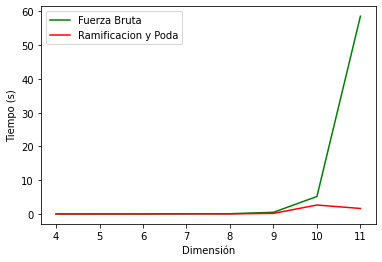

In [ ]:
plt.plot(list(range(4, 12)), tiempos_fuerza_bruta, color='green', label='Fuerza Bruta')
plt.plot(list(range(4, 12)), tiempos_ramificacion_y_poda, color='red', label='Ramificacion y Poda')
plt.legend()
plt.xlabel('Dimensión')
plt.ylabel('Tiempo (s)')

Vemos que una vez llegamos a problemas de dimensión 11 o mayor, el algoritmo de fuerza bruta se vuelve muy ineficiente en comparación con el algoritmo de ramificación y poda. Ahora, comprobamos si existe alguna dimensión a partir de la cual el algoritmo de ramificación y poda también se vuelve inviable.

In [ ]:
tiempos_ramificacion_y_poda = []

for n in range(4, 15):
    
    costes = [[random.randrange(0, 50) for _ in range(n)] for _ in range(n)]
    
    inicio = time()
    _ = ramificacion_y_poda(costes)
    tiempos_ramificacion_y_poda.append(time() - inicio)
    

Text(0, 0.5, 'Tiempo (s)')

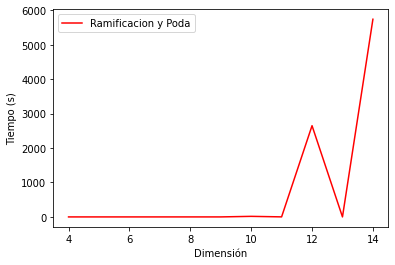

In [ ]:
plt.plot(list(range(4, 15)), tiempos_ramificacion_y_poda, color='red', label='Ramificacion y Poda')
plt.legend()
plt.xlabel('Dimensión')
plt.ylabel('Tiempo (s)')

Vemos que al utilizar ramificación y poda obtenemos tiempos razonables hasta llegar a valores de dimensión 14 o mayor.

## Descenso del gradiente: Parte 1

Vamos a buscar el mínimo de la función paraboloide: $$f(x) =  x² + y²$$

Obviamente se encuentra en (x,y)=(0,0) pero probaremos como llegamos a él a través del descenso del gradiente.

In [ ]:
f = lambda x: x[0]**2 + x[1]**2
grad_f = lambda x: [2*x[0], 2*x[1]]

grad_f([1,2])

[2, 4]

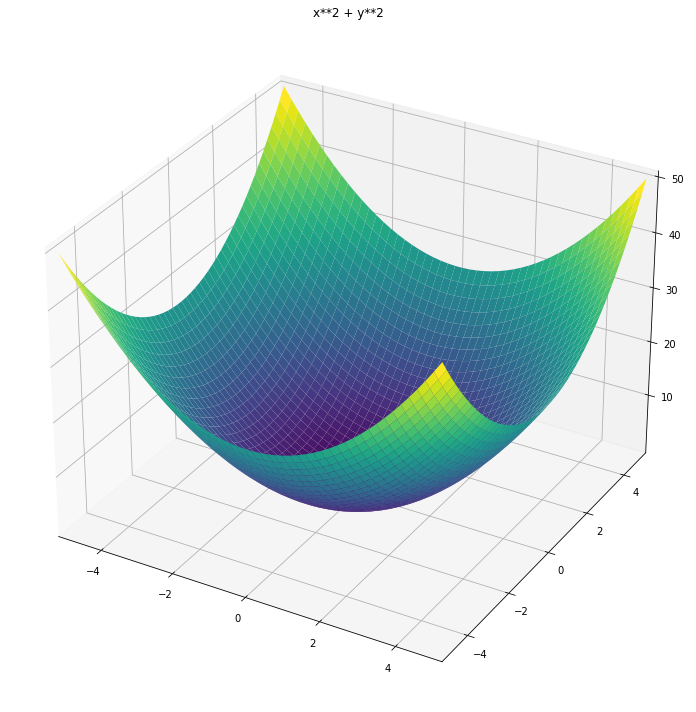

In [ ]:
from sympy import symbols
from sympy.plotting import plot
from sympy.plotting import plot3d
x, y = symbols('x y')
plot3d(x**2 + y**2,
       (x, -5, 5),(y, -5, 5),
       title='x**2 + y**2',
       size=(10, 10))

In [ ]:
def descenso_gradiente(grad_f, x_0, tasa_aprendizaje=0.1, iters=500):
    
    # Lista para guardar los puntos por los que pasa el algoritmo
    puntos = [x_0]
    
    for _ in range(iters):
        
        # Calculamos el gradiente.
        grad = grad_f(x_0)
        
        # Actualizamos el punto moviendonos en la dirección negativa del gradiente.
        x_0 = [x - tasa_aprendizaje*g for x, g in zip(x_0, grad)]
        
        puntos.append(x_0)
        
    return x_0, puntos

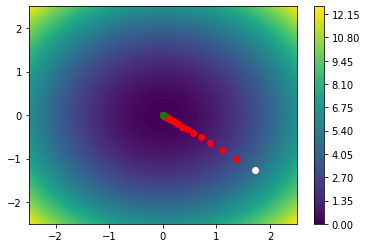

In [ ]:
#Prepara los datos para dibujar mapa de niveles de Z
resolucion = 100 
rango = 2.5
 
X = np.linspace(-rango, rango, resolucion) 
Y = np.linspace(-rango, rango, resolucion)
Z = np.zeros((resolucion, resolucion))
for ix, x in enumerate(X):
  for iy, y in enumerate(Y):
    Z[iy, ix] = f([x, y])

#Pinta el mapa de niveles de Z
plt.contourf(X, Y, Z, resolucion)
plt.colorbar() 

#Generamos un punto aleatorio inicial y pintamos de blanco
P = [random.uniform(-2, 2), random.uniform(-2, 2)]
plt.plot(P[0], P[1], 'o', c='white')

# Optimización con descenso de gradiente.
x_0, puntos = descenso_gradiente(grad_f, P)

plt.scatter([p[0] for p in puntos], [p[1] for p in puntos], color='red')
plt.scatter(x_0[0], x_0[1], color='green')

## Descendo gradiente: Parte 2

In [ ]:
g = lambda x: math.sin(1/2 * x[0]**2 - 1/4 * x[1]**2 + 3) * math.cos(2 * x[0] + 1 - math.exp(x[1]) )

In [ ]:
def gradiente_aprox(f, x, h=0.01):
    
    return [(f([x[0] + h, x[1]]) - f(x))/h, (f([x[0], x[1] + h]) - f(x))/h]


def descenso_gradiente_aprox(f, x_0, tasa_aprendizaje=0.01, iters=500):
    
    # Lista para guardar los puntos por los que pasa el algoritmo
    puntos = [x_0]
    
    for _ in range(iters):
        
        # Calculamos el gradiente.
        grad = gradiente_aprox(f, x_0)
        
        # Actualizamos el punto moviendonos en la dirección negativa del gradiente.
        x_0 = [x - tasa_aprendizaje*g for x, g in zip(x_0, grad)]
        
        puntos.append(x_0)
        
    return x_0, puntos

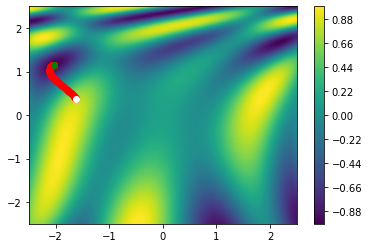

In [ ]:
#Prepara los datos para dibujar mapa de niveles de Z
resolucion = 100 
rango = 2.5
 
X = np.linspace(-rango, rango, resolucion) 
Y = np.linspace(-rango, rango, resolucion)
Z = np.zeros((resolucion, resolucion))
for ix, x in enumerate(X):
  for iy, y in enumerate(Y):
    Z[iy, ix] = g([x, y])

#Pinta el mapa de niveles de Z
plt.contourf(X, Y, Z, resolucion)
plt.colorbar() 

#Generamos un punto aleatorio inicial y pintamos de blanco
P = [random.uniform(-2, 2), random.uniform(-2, 2)]
plt.plot(P[0], P[1], 'o', c='white')

# Optimización con descenso de gradiente.
x_0, puntos = descenso_gradiente_aprox(g, P)

plt.scatter([p[0] for p in puntos], [p[1] for p in puntos], color='red')
plt.scatter(x_0[0], x_0[1], color='green')